<a href="https://colab.research.google.com/github/cselester/Real-time-Share-Price-scrapping-and-analysis/blob/main/Web_Scraping_for_Stock_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Real Time Stock Price Analysis Through Web Scrapping**

# 1. Data Extraction

a. 📥 Setup and Dependencies

In [43]:
!pip install openpyxl beautifulsoup4 lxml

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import userdata

b. 🌐 Source Configuration

In [44]:
API_KEY = userdata.get('KEY')
usd_inr_fallback = 83.0

symbols = {
    'AAPL': 'https://groww.in/us-stocks/aapl',
    'MSFT': 'https://groww.in/us-stocks/msft',
    'GOOGL': 'https://groww.in/us-stocks/googl',
    'TSLA': 'https://groww.in/us-stocks/tsla',
    'NVDA': 'https://groww.in/us-stocks/nvda'
}

headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 Chrome/84.0.4147.105 Safari/537.36'
}

c. Fetch Live USD to INR Rate

In [45]:
def get_usd_inr_rate():
    try:
        res = requests.get(
            f'https://www.alphavantage.co/query?function=CURRENCY_EXCHANGE_RATE&from_currency=USD&to_currency=INR&apikey={API_KEY}')
        fx = res.json()
        rate = float(fx["Realtime Currency Exchange Rate"]["5. Exchange Rate"])
        print(f"✅ Live USD to INR rate: ₹{rate}")
        return rate
    except Exception as e:
        print(f"⚠️ FX API failed, using fallback: ₹{usd_inr_fallback}")
        return usd_inr_fallback

usd_inr = get_usd_inr_rate()


✅ Live USD to INR rate: ₹85.151


d. Scrape or API Fallback for Stock Prices

In [29]:
data = []

for symbol, url in symbols.items():
    scraped = False
    try:
        res = requests.get(url, headers=headers)
        soup = BeautifulSoup(res.text, 'lxml')
        price_tag = soup.select_one('div.usph14PriceWrapper span')
        if price_tag:
            price_usd = float(price_tag.text.replace('$', '').replace(',', ''))
            price_inr = round(price_usd * usd_inr, 2)
            data.append([symbol, price_usd, price_inr, 'Scraped'])
            print(f"✅ [Scraped] {symbol}: ${price_usd} → ₹{price_inr}")
            scraped = True
    except Exception as e:
        print(f"❌ Scraping failed for {symbol}: {e}")

    if not scraped:
        try:
            api_url = f'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey={API_KEY}'
            res = requests.get(api_url)
            quote = res.json()['Global Quote']
            price_usd = float(quote['05. price'])
            price_inr = round(price_usd * usd_inr, 2)
            data.append([symbol, price_usd, price_inr, 'API'])
            print(f"✅ [API] {symbol}: ${price_usd} → ₹{price_inr}")
        except Exception as e:
            print(f"❌ API also failed for {symbol}: {e}")

    time.sleep(12)  # Prevent API rate limits


✅ [Scraped] AAPL: $195.27 → ₹16627.44
✅ [Scraped] MSFT: $450.18 → ₹38333.28
✅ [Scraped] GOOGL: $168.47 → ₹14345.39
✅ [Scraped] TSLA: $339.34 → ₹28895.14
✅ [Scraped] NVDA: $131.29 → ₹11179.47


# 2. Data Preprocessing

a. Load Data into DataFrame

In [30]:
df = pd.DataFrame(data, columns=['Symbol', 'Price (USD)', 'Price (INR)', 'Source'])

b. Clean Data

In [31]:
df.dropna(inplace=True)
df = df[~df.duplicated()]

c. Feature Engineering

In [32]:
df['Price (INR)'] = pd.to_numeric(df['Price (INR)'], errors='coerce')
df['Price (USD)'] = pd.to_numeric(df['Price (USD)'], errors='coerce')
df['Log Price INR'] = np.log1p(df['Price (INR)'])

d. Data Integrity Checks

In [33]:
df = df[(df['Price (INR)'] > 0) & (df['Price (USD)'] > 0)]

# 3. Exploratory Data Analysis (EDA)

a. Summary Statistics

In [34]:
print("\n📊 Summary Statistics:")
print(df[['Price (USD)', 'Price (INR)']].describe())


📊 Summary Statistics:
       Price (USD)   Price (INR)
count     5.000000      5.000000
mean    256.910000  21876.144000
std     133.743696  11388.410933
min     131.290000  11179.470000
25%     168.470000  14345.390000
50%     195.270000  16627.440000
75%     339.340000  28895.140000
max     450.180000  38333.280000


b. Anomaly Detection

In [35]:
z_scores = np.abs((df["Price (INR)"] - df["Price (INR)"].mean()) / df["Price (INR)"].std())
df["Anomaly"] = z_scores > 2

c. Visualizations

Bar Chart

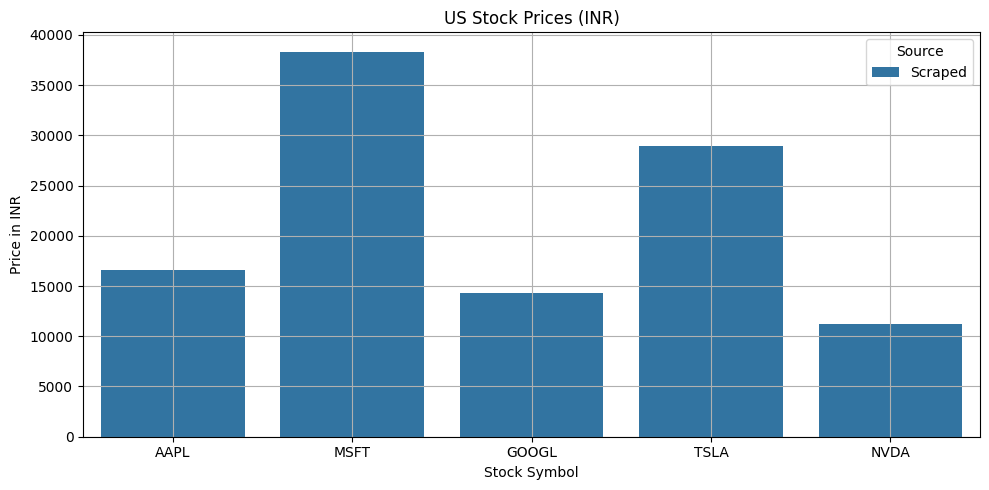

In [36]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Symbol', y='Price (INR)', data=df, hue='Source')
plt.title("US Stock Prices (INR)")
plt.xlabel("Stock Symbol")
plt.ylabel("Price in INR")
plt.grid(True)
plt.tight_layout()
plt.show()

Anomaly Scatter Plot

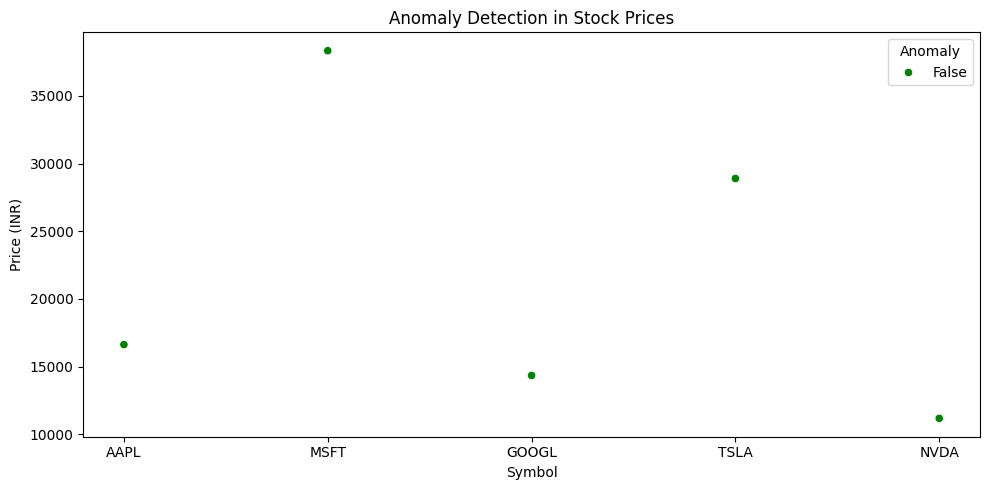

In [37]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Symbol', y='Price (INR)', hue='Anomaly', data=df, palette={True: "red", False: "green"})
plt.title("Anomaly Detection in Stock Prices")
plt.tight_layout()
plt.show()

Simulated Volume + Boxplot

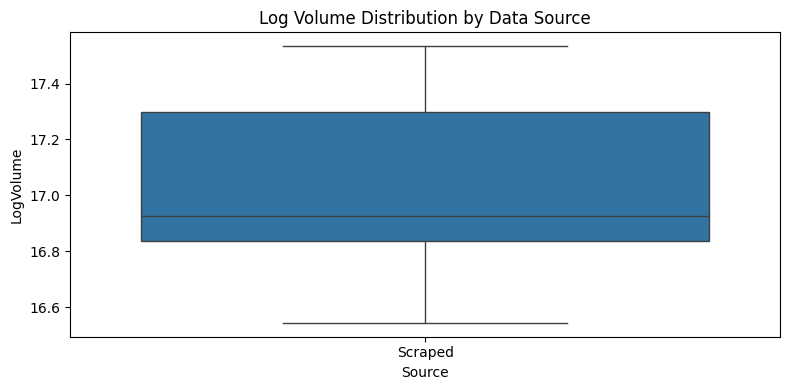

In [38]:
df['Volume'] = [32500000, 22400000, 15300000, 41200000, 20500000]  # Simulated values
df['LogVolume'] = np.log1p(df['Volume'])

plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='Source', y='LogVolume')
plt.title("Log Volume Distribution by Data Source")
plt.tight_layout()
plt.show()


# 4. Export Results

In [39]:
df.to_excel('us_stock_prices_analysis.xlsx', index=False)
print("📁 Saved to: us_stock_prices_analysis.xlsx")

📁 Saved to: us_stock_prices_analysis.xlsx
